In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
metric = "node_memory_MemAvailable_bytes"
#metric = "node_load1"

# Carregar o arquivo CSV
df = pd.read_csv("5G3E-dataset/SampleData/physical_level/server_1.csv", sep=";")

# Converter a coluna 'node_load1' para numérica e tratar NaN
df[metric] = pd.to_numeric(df[metric], errors='coerce')

# Remover linhas com NaN na coluna 'node_load1'
df = df.dropna(subset=[metric]).reset_index(drop=True)

df

/tmp/ipykernel_61973/2324389030.py:5: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262

,timestamp,"go_gc_duration_seconds{quantile=""0""}","go_gc_duration_seconds{quantile=""0.25""}","go_gc_duration_seconds{quantile=""0.5""}","go_gc_duration_seconds{quantile=""0.75""}","go_gc_duration_seconds{quantile=""1""}",go_gc_duration_seconds_sum,go_gc_duration_seconds_count,go_goroutines,"go_info{version=""go1.15.8""}",...,process_start_time_seconds,process_virtual_memory_bytes,process_virtual_memory_max_bytes,"promhttp_metric_handler_errors_total{cause=""encoding""}","promhttp_metric_handler_errors_total{cause=""gathering""}",promhttp_metric_handler_requests_in_flight,"promhttp_metric_handler_requests_total{code=""200""}","promhttp_metric_handler_requests_total{code=""500""}","promhttp_metric_handler_requests_total{code=""503""}",Unnamed: 1960
0,09:33:48.395,0.000096,0.000293,0.000606,0.00123,0.006097,24648.10391,47222820.0,8,1,...,1648230927.4,743444480.0,18446744073709551616.0,0,0,1,18004564.0,0,0,NaN
1,09:33:48.545,0.000096,0.000297,0.000621,0.001243,0.006097,24648.107104,47222823.0,7,1,...,1648230927.4,743444480.0,18446744073709551616.0,0,0,1,18004565.0,0,0,NaN
2,09:33:48.695,0.000096,0.000297,0.000631,0.001231,0.006097,24648.111181,47222826.0,7,1,...,1648230927.4,743444480.0,18446744073709551616.0,0,0,1,18004566.0,0,0,NaN
3,09:33:48.845,0.000096,0.000293,0.000621,0.001243,0.006097,24648.112863,47222829.0,7,1,...,1648230927.4,743444480.0,18446744073709551616.0,0,0,1,18004567.0,0,0,NaN
4,09:33:48.996,0.000096,0.000293,0.000637,0.001257,0.007695,24648.120791,47222831.0,7,1,...,1648230927.4,743444480.0,18446744073709551616.0,0,0,1,18004568.0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3994,09:51:00.882,0.000115,0.000377,0.000701,0.001271,0.014189,24659.445637,47233081.0,7,1,...,1648230927.4,743444480.0,18446744073709551616.0,0,0,1,18008558.0,0,0,NaN
3995,09:51:01.033,0.000115,0.000381,0.000701,0.001271,0.014189,24659.447914,47233084.0,7,1,...,1648230927.4,743444480.0,18446744073709551616.0,0,0,1,18008559.0,0,0,NaN
3996,09:51:01.183,0.000115,0.000377,0.000699,0.001269,0.014189,24659.449236,47233086.0,8,1,...,1648230927.4,743444480.0,18446744073709551616.0,0,0,1,18008560.0,0,0,NaN
3997,09:51:01.333,0.000115,0.000381,0.000687,0.001269,0.014189,24659.451917,47233089.0,7,1,...,1648230927.4,743444480.0,18446744073709551616.0,0,0,1,18008561.0,0,0,NaN


In [39]:
df[metric]

0       1.489480e+11
1       1.489480e+11
2       1.489437e+11
3       1.489462e+11
4       1.489475e+11
            ...     
3994    1.488596e+11
3995    1.488630e+11
3996    1.488622e+11
3997    1.488623e+11
3998    1.488631e+11
Name: node_memory_MemAvailable_bytes, Length: 3999, dtype: float64

In [85]:
columns = [column.split("{")[0] for column in df.columns]

with open("physical_level_metrics.txt", "a") as f:
    for column in set(columns):
        f.write(column)
        f.write("\n")
    f.close()

In [40]:
total_samples = len(df)

total_ram = df["node_memory_MemTotal_bytes"].astype("float64")[0]

metric_data = df[metric] / total_ram

#metric_data = df[metric]

#metric_data = [float(metric_data[idx+1] - metric_data[idx]) for idx in range(total_samples - 1)]

#metric_data = [element if element >= 0 else 0 for element in metric_data]

#metric_data = [element if element >= 0 else 0 for element in metric_data]

In [41]:
metric_data

0       0.734473
1       0.734473
2       0.734452
3       0.734464
4       0.734470
          ...   
3994    0.734037
3995    0.734054
3996    0.734050
3997    0.734050
3998    0.734054
Name: node_memory_MemAvailable_bytes, Length: 3999, dtype: float64

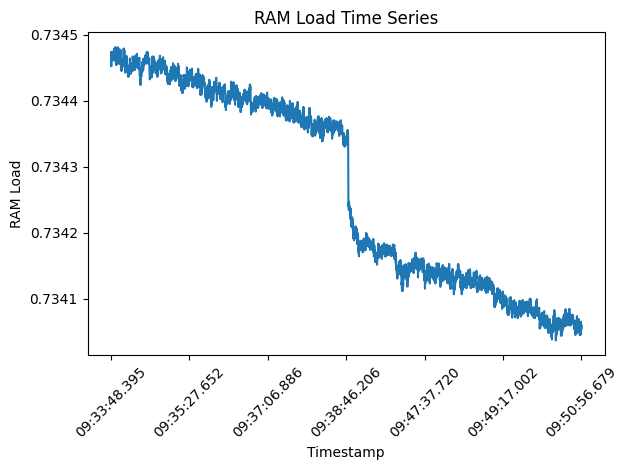

In [43]:
total_experiment_samples = len(df) - 30
#total_experiment_samples = 0
start_sample = 0

plt.plot(df["timestamp"][start_sample:total_experiment_samples], metric_data[start_sample:total_experiment_samples])
plt.title("RAM Load Time Series")
plt.xlabel("Timestamp")
plt.ylabel("RAM Load")

n = 6
ticks = df["timestamp"][start_sample:total_experiment_samples][start_sample:total_experiment_samples:int(len(df["timestamp"][start_sample:total_experiment_samples])/n)]
plt.xticks(ticks, rotation=45)

plt.tight_layout()
plt.show()

In [44]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

# Supondo que 'node_load1' seja seu dataset original e 'total_samples' é o número total de amostras desejado
dataset = np.array(metric_data[:total_samples])

# Reshape para garantir que os dados tenham a forma correta (2D)
dataset_scaled = dataset.reshape(-1, 1)  # Transforma para (n_samples, 1)

# Criando e ajustando o StandardScaler aos dados
#dataset_scaler = StandardScaler().fit(dataset)

# Exemplo de transformação dos dados
#dataset_scaled = dataset_scaler.transform(dataset)

# Verificando a forma transformada dos dados
#print("Shape depois do reshape e transformação:", dataset_scaled.shape)

step = 395 # 1 minuto a frente equivale à 395 amostras a frente no timestamp

X, y = [], []

for i in range(len(dataset_scaled)-step):
    feature = dataset_scaled[i]
    target = dataset_scaled[i+step]
    X.append(feature)
    y.append(target)
    
X_data = torch.tensor(X)
y_data = torch.tensor(y)

print(X_data.shape, y_data.shape)


torch.Size([3604, 1]) torch.Size([3604, 1])


In [45]:
X_data

tensor([[0.7345],
        [0.7345],
        [0.7345],
        ...,
        [0.7341],
        [0.7341],
        [0.7341]], dtype=torch.float64)

In [46]:
y_data

tensor([[0.7345],
        [0.7344],
        [0.7345],
        ...,
        [0.7341],
        [0.7341],
        [0.7341]], dtype=torch.float64)

In [133]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

class CPULSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=2, batch_first=True)  # Reduzindo o número de camadas e o tamanho da camada oculta
        self.linear = nn.Linear(256, 1)
        
    def forward(self, x):
        x = x.unsqueeze(-1)
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
    
def init_weights(module):
    if isinstance(module, nn.LSTM):
        for name, param in module.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
    
model = CPULSTM()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)  # Reduzindo a taxa de aprendizado

loss_fn = nn.MSELoss()

# Verifique se X_data e y_data estão corretamente carregados e não contêm NaNs
X_data_tensor = torch.tensor(X_data, dtype=torch.float32).clone().detach()
y_data_tensor = torch.tensor(y_data, dtype=torch.float32).clone().detach()

dataset = TensorDataset(X_data_tensor, y_data_tensor)
data_loader = DataLoader(dataset, shuffle=True, batch_size=64)

model.to(device)

n_epochs = 2000
max_consecutive_increases = 10  # Aumentando o número máximo de aumentos consecutivos de RMSE antes de parar
train_rmse_history = []
consecutive_increases = 0

for epoch in range(n_epochs):
    for X_batch, y_batch in data_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    
    # Avaliação do modelo no final de cada época
    with torch.no_grad():
        model.eval()  # Colocando o modelo em modo de avaliação
        y_pred = model(X_data_tensor.to(device))
        train_rmse = np.sqrt(loss_fn(y_pred.cpu(), y_data_tensor).item())
        model.train()  # Voltando o modelo para o modo de treinamento
    
    train_rmse_history.append(train_rmse)
    print(f"Epoch {epoch}: train RMSE {train_rmse}")
    
    # Verificação do critério de parada
    if len(train_rmse_history) > 1 and train_rmse > train_rmse_history[-2]:
        consecutive_increases += 1
    else:
        consecutive_increases = 0
    
    if consecutive_increases >= max_consecutive_increases:
        print(f"Early stopping at epoch {epoch} due to consecutive increases in RMSE.")
        break

/tmp/ipykernel_10012/1606701009.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_data_tensor = torch.tensor(X_data, dtype=torch.float32).clone().detach()
/tmp/ipykernel_10012/1606701009.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data_tensor = torch.tensor(y_data, dtype=torch.float32).clone().detach()
/media/HD/Projetos_DS/venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/media/HD

Epoch 0: train RMSE 0.7115804678181719
Epoch 1: train RMSE 0.7033439083532232
Epoch 2: train RMSE 0.6948679027644402
Epoch 3: train RMSE 0.6860217544495573
Epoch 4: train RMSE 0.6766901684267403
Epoch 5: train RMSE 0.6667636016070531
Epoch 6: train RMSE 0.6561362985476453
Epoch 7: train RMSE 0.6447085512379033
Epoch 8: train RMSE 0.6323883141983985
Epoch 9: train RMSE 0.6190909717758003
Epoch 10: train RMSE 0.6047390878835394
Epoch 11: train RMSE 0.5892615065618486
Epoch 12: train RMSE 0.5725927361919328
Epoch 13: train RMSE 0.5546772915612669
Epoch 14: train RMSE 0.5354756147191173
Epoch 15: train RMSE 0.5149663128066273
Epoch 16: train RMSE 0.4931486675012388
Epoch 17: train RMSE 0.47004554053602404
Epoch 18: train RMSE 0.44570773136523467
Epoch 19: train RMSE 0.42021733025505115
Epoch 20: train RMSE 0.39369102747878565
Epoch 21: train RMSE 0.36628352145267
Epoch 22: train RMSE 0.33818961569667655
Epoch 23: train RMSE 0.309644708207937
Epoch 24: train RMSE 0.28092378665607387
Epoch 2

In [134]:
model_name = "ramlstm.pt"

torch.save(model, f"models/{model_name}")

##### **RAMLSTM**

Dataset Path: "5G3E-dataset/SampleData/physical_level/server_1.csv"

Server ID: 1

Metric: node_memory_MemAvailable_bytes

Total Dataset Samples: 3603

Total Epochs: 2000

Train RMSE: 0.00014282103746792422

Hidden States: 256

Linear Layers: 1

Initializations: Xavier and Orthogonal

Number of Layers: 2

Optimizer: Adam

Learning Rate: 1e-5

Weight Decay: 1e-5

Loss: MSELoss

Batch Size: 64



##### **CPULSTM**

Dataset Path: "5G3E-dataset/SampleData/physical_level/server_1.csv"

Server ID: 1

Metric: node_load1

Total Dataset Samples: 3604

Total Epochs: 2000

Train RMSE: 2.7274245508879127

Hidden States: 256

Linear Layers: 1

Initializations: Xavier and Orthogonal

Number of Layers: 2

Optimizer: Adam

Learning Rate: 1e-5

Weight Decay: 1e-5

Loss: MSELoss

Batch Size: 64

In [144]:
X_data

tensor([[116.9200],
        [116.9200],
        [116.9200],
        ...,
        [112.8200],
        [114.3500],
        [114.3500]], dtype=torch.float64)

# Anomalies

Anomalias detectadas nos índices: []


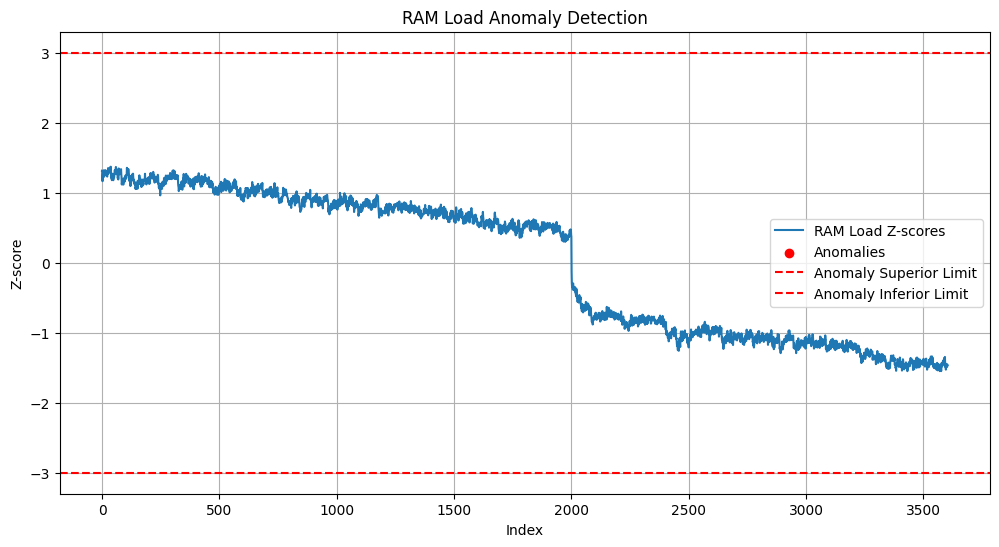

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Suponha que X_data seja um tensor do PyTorch
X_data_np = X_data.numpy()

# Calculando a média e o desvio padrão da série
mean = np.mean(X_data_np)
std_dev = np.std(X_data_np)

# Convertendo todos os dados para z-scores
z_scores = (X_data_np - mean) / std_dev

# Definindo um limite para detecção de anomalias (por exemplo, z-scores maior que 3)
anomaly_cutoff = 3

# Identificando anomalias com base nos z-scores
anomalies = np.where(np.abs(z_scores) > anomaly_cutoff)[0]

print("Anomalias detectadas nos índices:", anomalies)

m = "RAM Load"

# Plotando a série temporal com z-scores e destacando as anomalias
plt.figure(figsize=(12, 6))
plt.plot(z_scores, label=f'{m} Z-scores')
plt.scatter(anomalies, z_scores[anomalies], color='red', label='Anomalies')
plt.axhline(y=anomaly_cutoff, color='r', linestyle='--', label='Anomaly Superior Limit')
plt.axhline(y=-anomaly_cutoff, color='r', linestyle='--', label='Anomaly Inferior Limit')
plt.xlabel('Index')
plt.ylabel('Z-score')
plt.title(f'{m} Anomaly Detection')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# Encontrando o menor valor dentre as anomalias identificadas
min_anomaly = np.min(X_data_np[anomalies])

print("Minimum Anomaly:", min_anomaly)

Minimum Anomaly: 3.11296


# Model Evaluation

In [ ]:
model = torch.load("models/cpulstm.pt")

In [ ]:
model.to(torch.device("cpu"))
model(X_data_tensor[0])